
# Translation with a Sequence to Sequence Network and Attention
*************************************************************
In this project, I am trying to develop a rudimentary Neural Machine Translation 
model that can provide sequence to sequence translation based on input translation
pairs of 2 languages such as English-French or English-Spanish etc.


This is made possible by the simple but powerful idea of the `sequence to sequence network <http://arxiv.org/abs/1409.3215>`
A Sequence to Sequence network, or seq2seq network - a model consisting of two separate RNNs called the encoder and decoder.
The encoder reads an input sequence one item at a time, and outputs a vector at each step. The final output of the encoder is kept used in another neural layer to give attention weights. The decoder uses this combined attention weights and encoder output as input to produce a sequence of outputs one step at a time.

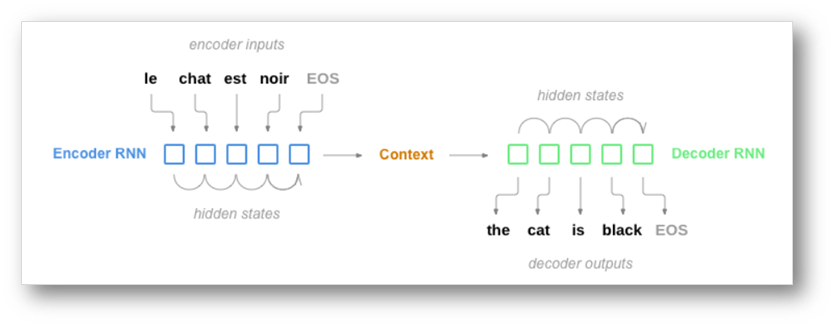


To improve upon this model we'll use an `attention mechanism <https://arxiv.org/abs/1409.0473>` The attention mechanism addresses this by giving the decoder a way to "pay attention" to parts of the input, rather than relying on a single vector

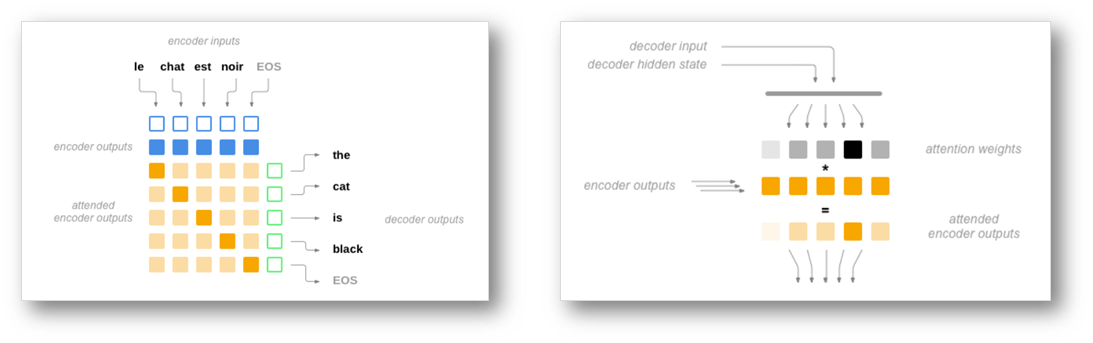

The following are some references:

1. `Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation <http://arxiv.org/abs/1406.1078>`
2. `Sequence to Sequence Learning with Neural Networks <http://arxiv.org/abs/1409.3215>`
3. `Neural Machine Translation by Jointly Learning to Align and Translate <https://arxiv.org/abs/1409.0473>`
4. `A Neural Conversational Model <http://arxiv.org/abs/1506.05869>`

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

'''from google.colab import drive
drive.mount('/content/gdrive/')'''

"from google.colab import drive\ndrive.mount('/content/gdrive/')"

# Loading data & Preprocessing

We create a unique index per word to use as the inputs and targets of the networks later. 

In [0]:
import os
os.chdir("gdrive/My Drive/Colab Notebooks/")

In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.



In [4]:
# Convert the unicode to ASCII and normalize to english characters without indents etc.
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Convert string to lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split
lines into pairs.




In [18]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('Language Repository/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make class Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

We set maximum 15 words so that we can train the model quickly.




In [6]:
MAX_LENGTH = 15

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH # and p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

Here, we are looking to train the seq2seq model for English-Hungarian


In [19]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'ces', False)
print(random.choice(pairs))

Reading lines...
Read 10518 sentence pairs
Trimmed to 10345 sentence pairs
Counting words...
Counted words:
eng 3957
ces 8323
['do you live by yourself ?', 'zijes sam ?']


# The Encoder


The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

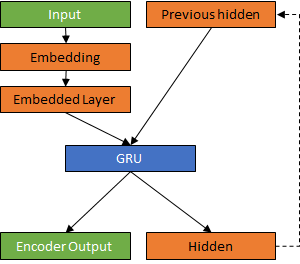

In [92]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.dropout = nn.Dropout(p=0.2)
        #self.gru = nn.GRU(hidden_size, hidden_size, batch_first=False, bidirectional=True)
        self.bi_gru = nn.GRU(hidden_size, hidden_size, num_layers=1, batch_first=False,bidirectional=True)
        #self.reverse_gru = nn.GRU(hidden_size,hidden_size, num_layers=1,batch_first=False,bidirectional=False)


    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        #output, hidden = self.gru(output, hidden)
        bi_output, bi_hidden = self.bi_gru(output,hidden)
        bi_output = (bi_output[:, :, :self.hidden_size] +
                     bi_output[:, :, self.hidden_size:])
        #reverse_output, reverse_hidden = self.reverse_gru(output,hidden)
        
        return bi_output, bi_hidden

    def initHidden(self):
        return torch.zeros(2, 1, self.hidden_size, device=device)

# Attention Decoder


The attention mechanism addresses this by giving the decoder a way to "pay attention" to parts of the input, rather than relying on a single vector. For every step the decoder can select a different part of the input sentence to consider.

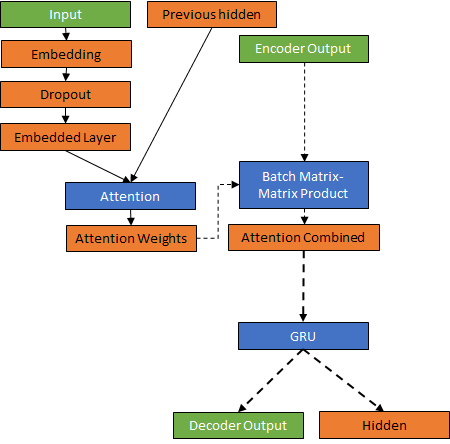




In [93]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.2, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size  #hidden size changed
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Preparing data for training

In [94]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

# Training the model

In [95]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, 
          max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden[0])
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden[0,:,hidden_size]

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [96]:
# Functions to measure time during the iterations
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

We iniatilize Negative Log Loss as criterion and SGD optimizers with learning rate of 0.0001

In [97]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.0001):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

# Plotting results

In [98]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

# Evaluation

In [99]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden*2

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [100]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

# Training and Evaluating

In [101]:
hidden_size = 512
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 100000, print_every=5000)

RuntimeError: Expected hidden size (2, 1, 512), got (1, 512)

In [22]:
evaluateRandomly(encoder1, attn_decoder1, n=10)

> you deserve more .
= tobbet erdemelsz .
< tobbet tobbet tudsz . <EOS>

> there s a lot on my mind .
= sok minden jar a fejemben .
< sok sok a a . <EOS>

> it is next to impossible to go to school .
= csaknem lehetetlen iskolaba menni .
< az iskolaba iskolaba menni . <EOS>

> you made things worse .
= mindent elrontottal .
< sokat sokat uszni . <EOS>

> i lived in a small town .
= egy kisvarosban eltem .
< egy a . . <EOS>

> these flowers have died .
= a viragok elszaradtak .
< ezek a a . . . <EOS>

> she is as beautiful as snow white .
= olyan szep mint a hofeherke .
< olyan szep mint a . . . <EOS>

> don t be so rough on yourself .
= ne legy oly kimeletlen magaddal szemben .
< ne legyel olyan olyan ! <EOS>

> i have plans .
= vannak terveim .
< van van . . <EOS>

> i m accustomed to sleeping in a room without air conditioning .
= hozzaszoktam a legkondicionalatlan szobakban valo alvasra .
< felek hogy hogy egy a <EOS>



Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




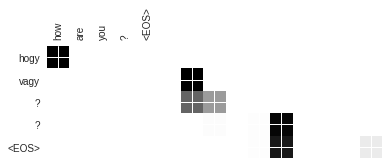

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

input_sentence = "how are you ?"

output_words, attentions = evaluate(encoder1, attn_decoder1, input_sentence )

fig = plt.figure()

ax = fig.add_subplot(111)
cax = ax.matshow(attentions.numpy(), cmap=plt.cm.binary)

ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
ax.set_yticklabels([''] + output_words)


ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))


plt.show()

For a better viewing experience we will do the extra work of adding axes
and labels:




input = it was a good thing that happened 
output = jo ember volt a a . <EOS>


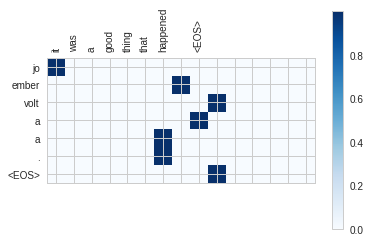

In [24]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    import seaborn as sns
    sns.set_style('whitegrid')
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("it was a good thing that happened ")

input = are you hungry
output = nem vagyunk . . <EOS>


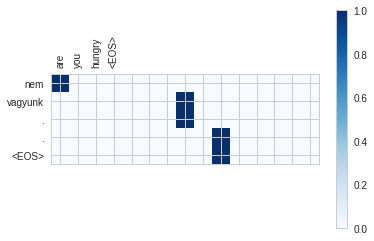

In [25]:
evaluateAndShowAttention("are you hungry")